# Etapa 3: Emparelhamento de Características (Matching)

**Objetivo:** Utilizar os keypoints e descritores extraídos na Etapa 2 para encontrar correspondências entre pares de imagens consecutivas.

**Pipeline:**
1.  **Carregar Dados:** Ler os arquivos `.npz` (keypoints/descritores) e `ordem_imagens.json` da Etapa 2.
2.  **Emparelhar (Matching):** Aplicar e comparar dois algoritmos:
    - **Brute-Force Matcher (BFMatcher):** Compara cada descritor da primeira imagem com todos os da segunda.
    - **FLANN (Fast Library for Approximate Nearest Neighbors):** Algoritmo otimizado para busca rápida em grandes conjuntos de dados.
3.  **Filtrar:** Aplicar o **Ratio Test de David Lowe** para remover correspondências ambíguas e manter apenas os matches de alta confiança.
4.  **Salvar Resultados:** Armazenar os matches filtrados em arquivos `.npz` para a Etapa 4 (Cálculo de Homografia).
5.  **Visualizar e Analisar:** Gerar imagens de visualização e uma tabela comparativa final.

In [1]:
import os
import glob
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

## Funções Auxiliares (Carregamento, Salvamento e Visualização)

In [2]:
def desserializar_keypoints(arr: np.ndarray) -> List[cv2.KeyPoint]:
    """
    Reconstrói lista de cv2.KeyPoint a partir do array (N,7).
    """
    kps = []
    for row in arr:
        k = cv2.KeyPoint(
            x=float(row[0]), y=float(row[1]), size=float(row[2]),
            angle=float(row[3]), response=float(row[4]),
            octave=int(row[5]), class_id=int(row[6])
        )
        kps.append(k)
    return kps

def carregar_features_npz(caminho_npz: str) -> Tuple[List[cv2.KeyPoint], np.ndarray, str]:
    """
    Lê um .npz salvo pela Etapa 2 e retorna (keypoints, descriptors, imagem_absoluta).
    """
    with np.load(caminho_npz, allow_pickle=True) as data:
        kps = desserializar_keypoints(data["keypoints"])
        desc = data["descriptors"]
        img_path = str(data["imagem_absoluta"])
    return kps, desc, img_path

def salvar_matches_npz(caminho_saida: str, matches: List[cv2.DMatch]):
    """
    Converte uma lista de matches para um array (N,3) e salva em .npz.
    Colunas: (queryIdx, trainIdx, distance)
    """
    if not matches:
        data = np.zeros((0, 3), dtype=np.float32)
    else:
        data = np.array([[m.queryIdx, m.trainIdx, m.distance] for m in matches], dtype=np.float32)
    np.savez_compressed(caminho_saida, matches=data)

def desenhar_matches_custom(
    img1, kps1, img2, kps2, matches,
    num_matches_a_desenhar=25,
    cor_linha=(255, 0, 255), espessura_linha=3,
    cor_ponto=(0, 255, 0), raio_ponto=15
):
    """Desenha matches entre duas imagens com linhas e pontos customizáveis."""
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    output_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    output_img[:h1, :w1] = img1
    output_img[:h2, w1:] = img2

    if kps1 is None or kps2 is None:
        return output_img

    for match in matches[:num_matches_a_desenhar]:
        pt1_idx = match.queryIdx
        pt1 = (int(kps1[pt1_idx].pt[0]), int(kps1[pt1_idx].pt[1]))
        pt2_idx = match.trainIdx
        pt2 = (int(kps2[pt2_idx].pt[0] + w1), int(kps2[pt2_idx].pt[1]))
        cv2.line(output_img, pt1, pt2, cor_linha, espessura_linha)
        cv2.circle(output_img, pt1, raio_ponto, cor_ponto, thickness=-1)
        cv2.circle(output_img, pt2, raio_ponto, cor_ponto, thickness=-1)
        
    return output_img

## Funções de Emparelhamento (Matching) e Filtragem

In [3]:
def criar_matcher(nome_matcher: str, desc_dtype):
    """
    Cria um objeto matcher (BF ou FLANN) configurado corretamente.
    """
    nome_matcher = nome_matcher.lower()

    if nome_matcher == 'bf':
        norm_type = cv2.NORM_L2 if desc_dtype == np.float32 else cv2.NORM_HAMMING
        return cv2.BFMatcher(norm_type)

    if nome_matcher == 'flann':
        if desc_dtype == np.float32:  # Para SIFT
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        else:  # Para ORB/AKAZE (descritores binários)
            FLANN_INDEX_LSH = 6
            index_params = dict(
                algorithm=FLANN_INDEX_LSH,
                table_number=6, key_size=12, multi_probe_level=1
            )
        search_params = dict(checks=50)
        return cv2.FlannBasedMatcher(index_params, search_params)

    raise ValueError(f"Matcher '{nome_matcher}' não reconhecido.")


def filtrar_matches_ratio_test(matches_brutos, ratio=0.75):
    """
    Aplica o Ratio Test de David Lowe para filtrar matches ambíguos.
    Requer que os matches tenham sido encontrados com k=2.
    """
    matches_filtrados = []
    # Itera de forma segura, verificando o tamanho de cada resultado
    for match_pair in matches_brutos:
        # Garante que temos 2 vizinhos para desempacotar, evitando o ValueError
        if len(match_pair) == 2:
            m, n = match_pair  # Desempacota somente se for seguro
            if m.distance < ratio * n.distance:
                matches_filtrados.append(m)
    return matches_filtrados

## Pipeline Principal da Etapa 3

In [4]:
def analisar_matches_conjunto(caminho_base_etapa2: str, matchers_a_usar: List[str]):
    """
    Pipeline da Etapa 3: Carrega features, realiza matching, filtra, salva e visualiza.
    """
    print(f"\n{'='*65}\nAnalisando Matches para o conjunto: '{os.path.basename(caminho_base_etapa2)}'\n{'='*65}")

    # Carrega a ordem das imagens
    caminho_json = os.path.join(caminho_base_etapa2, "ordem_imagens.json")
    try:
        with open(caminho_json, "r") as f:
            arquivos_de_imagem_abs = json.load(f)
    except FileNotFoundError:
        print(f"[Erro] 'ordem_imagens.json' não encontrado em '{caminho_base_etapa2}'. Abortando.")
        return
    
    # Itera sobre os detectores (sift, orb, etc.)
    detectores = [d for d in os.listdir(caminho_base_etapa2) if os.path.isdir(os.path.join(caminho_base_etapa2, d))]
    for nome_detector in detectores:
        print(f"\n--- Detector: {nome_detector.upper()} ---")
        caminho_detector = os.path.join(caminho_base_etapa2, nome_detector)
        
        # Carrega todos os arquivos de features para este detector
        arquivos_npz = sorted(glob.glob(os.path.join(caminho_detector, "*_features.npz")))
        if len(arquivos_npz) < 2:
            continue

        # Itera sobre os matchers (bf, flann)
        for nome_matcher in matchers_a_usar:
            print(f"  - Matcher: {nome_matcher.upper()}")
            
            # Cria o diretório de saída para esta combinação
            dir_saida = os.path.join("resultados_etapa3", os.path.basename(caminho_base_etapa2), nome_detector, nome_matcher)
            os.makedirs(dir_saida, exist_ok=True)

            # Itera sobre os pares de imagens
            for i in range(len(arquivos_npz) - 1):
                kps1, desc1, path1 = carregar_features_npz(arquivos_npz[i])
                kps2, desc2, path2 = carregar_features_npz(arquivos_npz[i+1])

                if desc1 is None or desc2 is None or desc1.shape[0] == 0 or desc2.shape[0] == 0:
                    salvar_matches_npz(os.path.join(dir_saida, f"matches_{i:03d}_{i+1:03d}.npz"), [])
                    continue

                matcher = criar_matcher(nome_matcher, desc1.dtype)
                matches_brutos = matcher.knnMatch(desc1, desc2, k=2)
                matches_filtrados = filtrar_matches_ratio_test(matches_brutos)
                
                # Salva os matches filtrados para a Etapa 4
                caminho_saida_npz = os.path.join(dir_saida, f"matches_{i:03d}_{i+1:03d}.npz")
                salvar_matches_npz(caminho_saida_npz, matches_filtrados)


                # Pega o nome do conjunto de imagens (ex: 'images-normal')
                nome_conjunto = os.path.basename(caminho_base_etapa2)
                conjuntos_para_preview = ["images-normal",
                                        "images-pro", "images-developed-png-16bit"]

                # Gera visualização apenas para o primeiro par, do detector SIFT, e somente para os conjuntos especificados
                if i == 0 and nome_detector.lower() == 'sift' and nome_conjunto in conjuntos_para_preview:
                    print(f"    -> Par 0-1: {len(matches_filtrados)} matches filtrados encontrados. Gerando preview...")
                    try:
                        img1 = cv2.imread(path1)
                        img2 = cv2.imread(path2)
                        preview = desenhar_matches_custom(img1, kps1, img2, kps2, matches_filtrados)
                    except Exception as e:
                        print(path1)
                        print(path2)
                        print(f"    [Erro] Não foi possível gerar o preview: {e}")
                        return
                    
                    caminho_saida_preview = os.path.join(dir_saida, "preview_matches_filtrados_par_0-1.jpg")
                    cv2.imwrite(caminho_saida_preview, preview)
                    
                    plt.figure(figsize=(20, 10))
                    plt.imshow(cv2.cvtColor(preview, cv2.COLOR_BGR2RGB))
                    plt.title(f'Matches Filtrados (Ratio Test) - {nome_detector.upper()}/{nome_matcher.upper()} - {len(matches_filtrados)} matches')
                    plt.axis('off')
                    plt.show()

## Execução do Pipeline para os Conjuntos de Imagens


Analisando Matches para o conjunto: 'images-developed-png-16bit'

--- Detector: ORB ---
  - Matcher: BF
  - Matcher: FLANN

--- Detector: AKAZE ---
  - Matcher: BF
  - Matcher: FLANN

--- Detector: SIFT ---
  - Matcher: BF
    -> Par 0-1: 206 matches filtrados encontrados. Gerando preview...


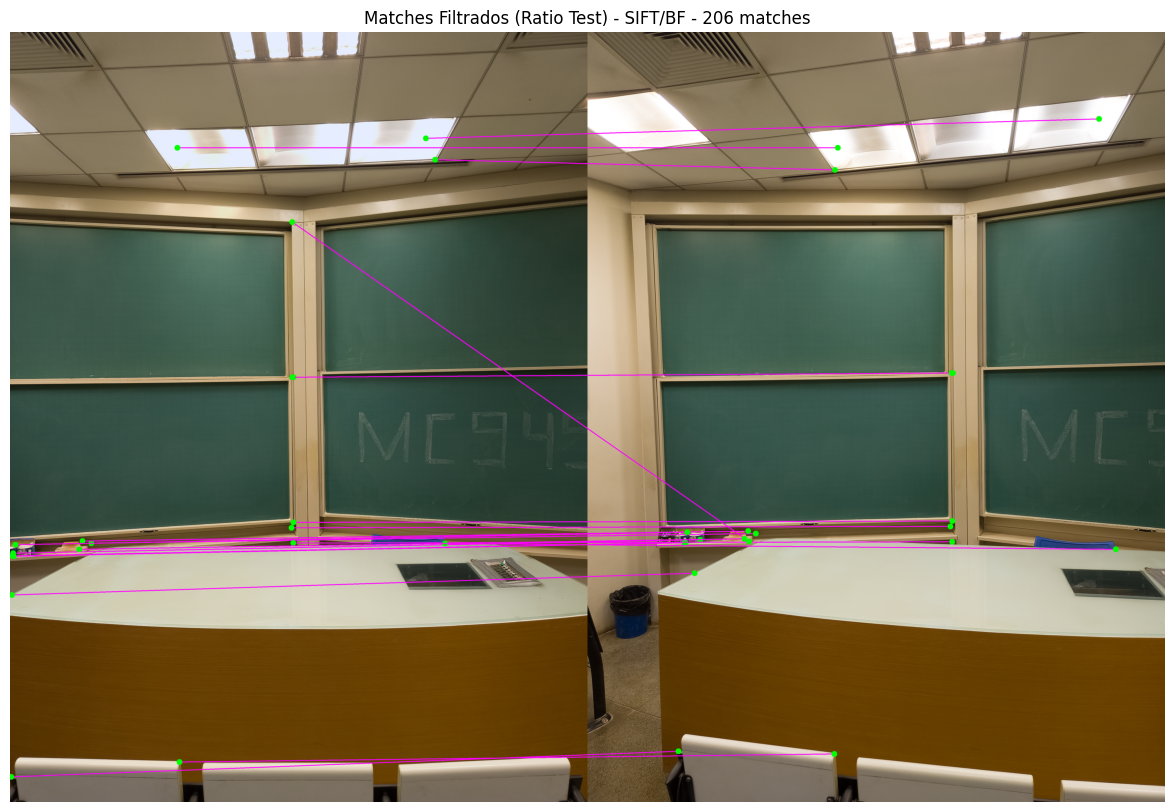

  - Matcher: FLANN
    -> Par 0-1: 208 matches filtrados encontrados. Gerando preview...


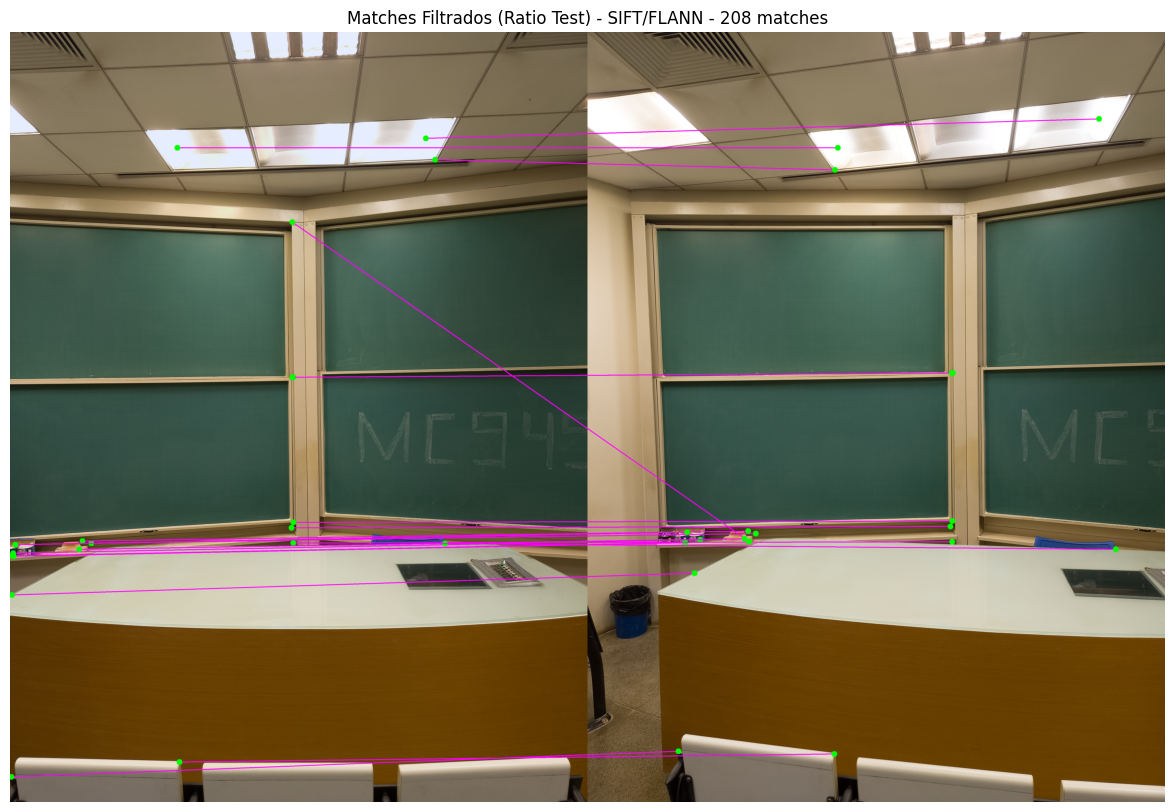


Analisando Matches para o conjunto: 'images-normal'

--- Detector: ORB ---
  - Matcher: BF
  - Matcher: FLANN

--- Detector: AKAZE ---
  - Matcher: BF
  - Matcher: FLANN

--- Detector: SIFT ---
  - Matcher: BF
    -> Par 0-1: 329 matches filtrados encontrados. Gerando preview...


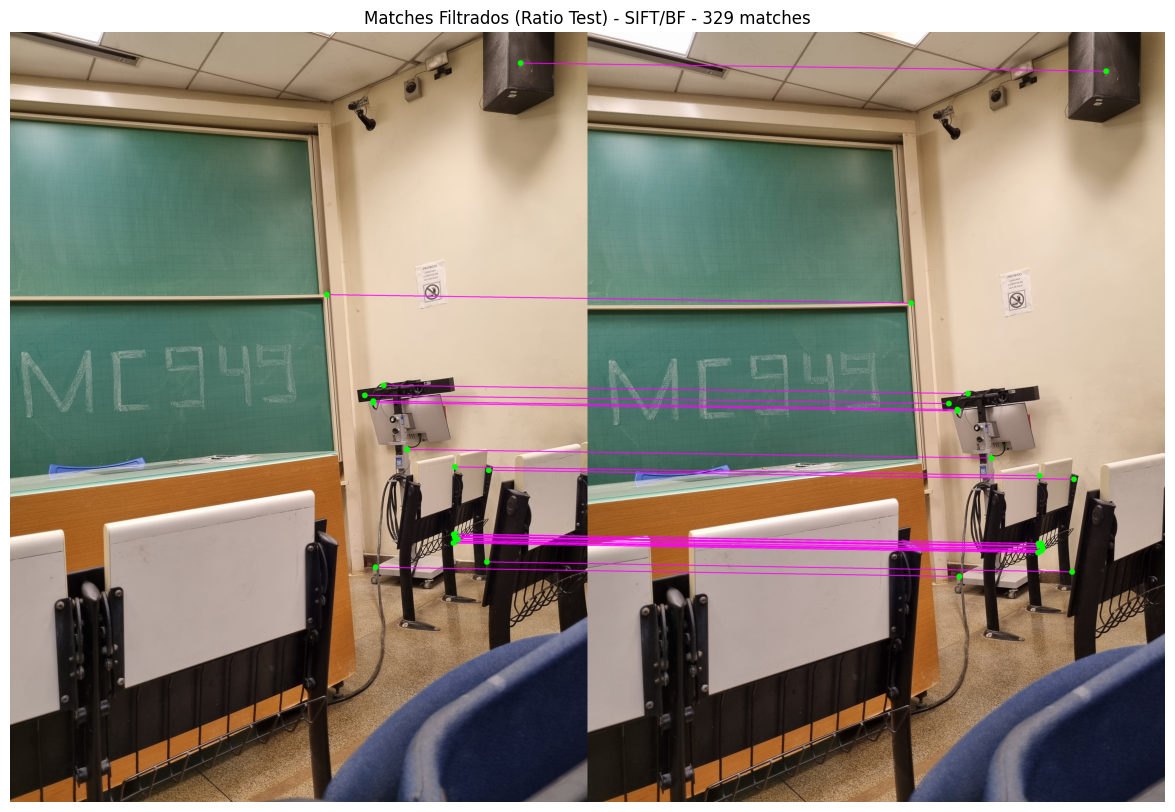

  - Matcher: FLANN
    -> Par 0-1: 329 matches filtrados encontrados. Gerando preview...


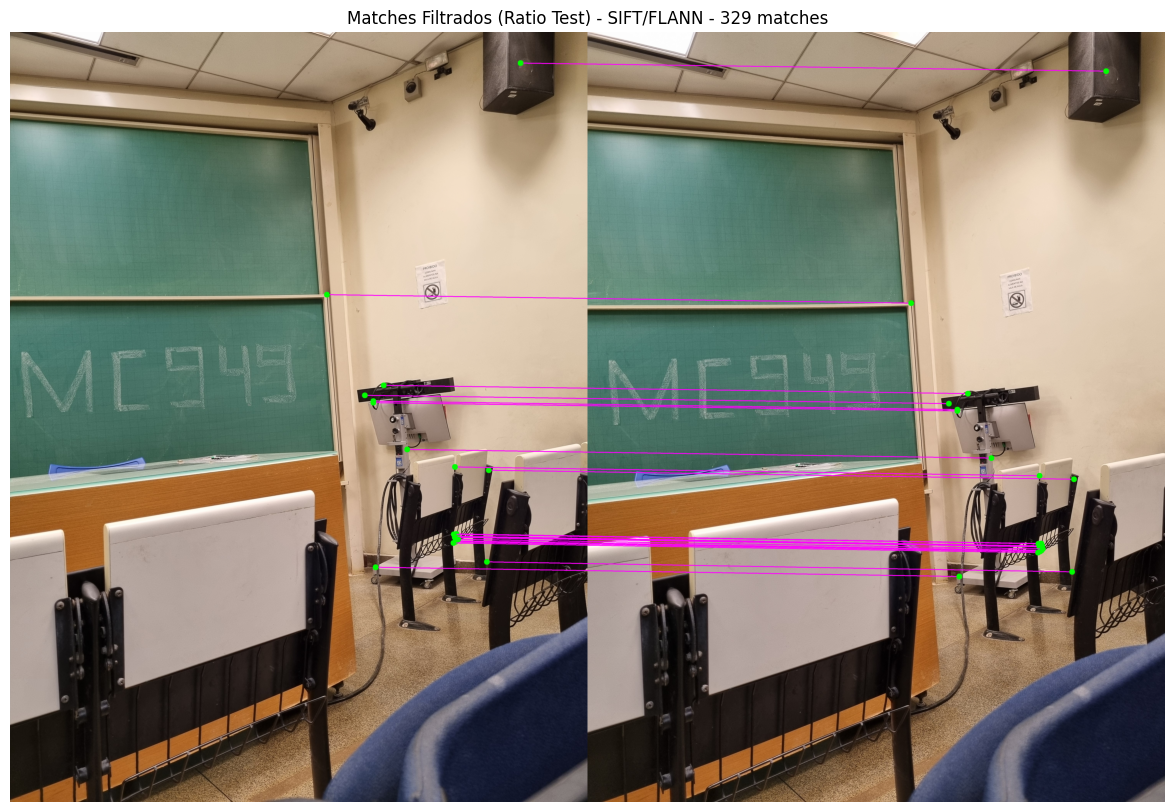


Analisando Matches para o conjunto: 'images-pro'

--- Detector: ORB ---
  - Matcher: BF
  - Matcher: FLANN

--- Detector: AKAZE ---
  - Matcher: BF
  - Matcher: FLANN

--- Detector: SIFT ---
  - Matcher: BF
    -> Par 0-1: 225 matches filtrados encontrados. Gerando preview...


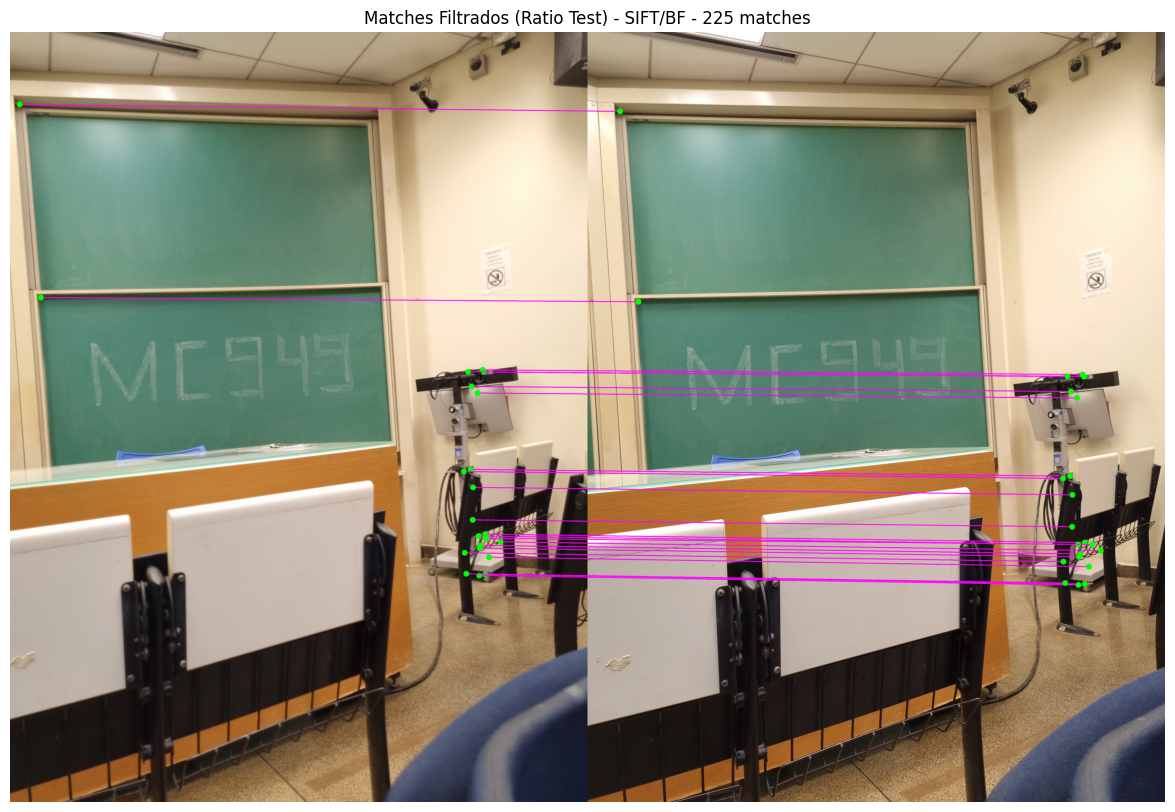

  - Matcher: FLANN
    -> Par 0-1: 226 matches filtrados encontrados. Gerando preview...


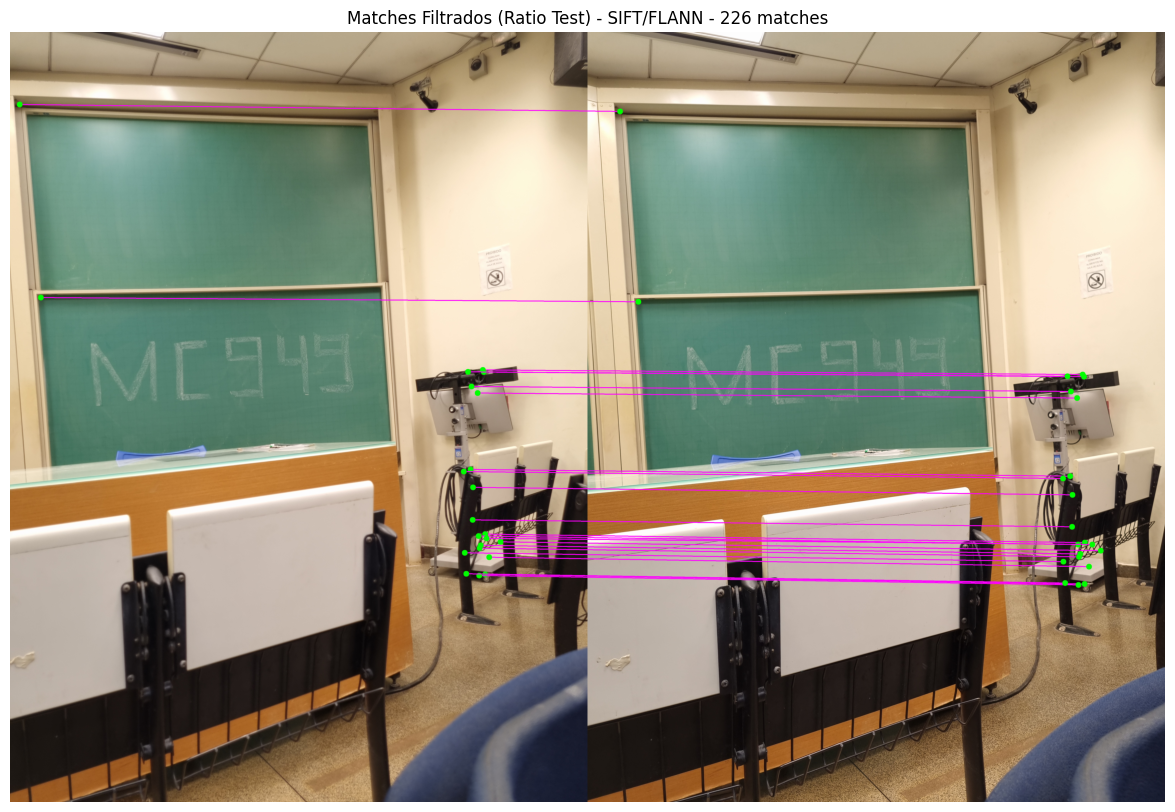

In [5]:
RAIZ_ETAPA2 = "resultados_etapa2"
MATCHERS = ['bf', 'flann']

conjuntos = [d for d in os.listdir(RAIZ_ETAPA2) if os.path.isdir(os.path.join(RAIZ_ETAPA2, d))]

for nome_conjunto in sorted(conjuntos):
    caminho_do_conjunto = os.path.join(RAIZ_ETAPA2, nome_conjunto)
    analisar_matches_conjunto(caminho_do_conjunto, MATCHERS)

## Geração do Relatório Comparativo Final

In [6]:
def gerar_relatorio_final_etapa3(raiz_resultados: str):
    """Gera uma tabela CSV comparando a média de matches por combinação."""
    print("\nGerando relatório comparativo final da Etapa 3...")
    dados_tabela = []
    
    # Navega pela estrutura de pastas gerada
    for nome_conjunto in sorted(os.listdir(raiz_resultados)):
        caminho_conjunto = os.path.join(raiz_resultados, nome_conjunto)
        if not os.path.isdir(caminho_conjunto): continue
            
        for nome_detector in sorted(os.listdir(caminho_conjunto)):
            caminho_detector = os.path.join(caminho_conjunto, nome_detector)
            if not os.path.isdir(caminho_detector): continue
                
            for nome_matcher in sorted(os.listdir(caminho_detector)):
                caminho_matcher = os.path.join(caminho_detector, nome_matcher)
                if not os.path.isdir(caminho_matcher): continue
                    
                arquivos_matches_npz = glob.glob(os.path.join(caminho_matcher, "matches_*.npz"))
                if not arquivos_matches_npz:
                    media_matches = 0.0
                else:
                    contagens = []
                    for npz in arquivos_matches_npz:
                        with np.load(npz) as data:
                            contagens.append(len(data['matches']))
                    media_matches = np.mean(contagens)
                
                dados_tabela.append({
                    "conjunto": nome_conjunto,
                    "detector": nome_detector,
                    "matcher": nome_matcher,
                    "media_matches_filtrados_por_par": media_matches
                })
    
    if not dados_tabela:
        print("Nenhum dado encontrado para gerar o relatório.")
        return

    df_final = pd.DataFrame(dados_tabela)
    df_final['media_matches_filtrados_por_par'] = df_final['media_matches_filtrados_por_par'].map('{:,.2f}'.format)
    
    print(f"\n{'='*80}\nRELATÓRIO COMPARATIVO FINAL - ETAPA 3\n{'='*80}")
    
    caminho_saida_final = os.path.join(raiz_resultados, "relatorio_comparativo_matches.csv")
    df_final.to_csv(caminho_saida_final, index=False, sep=';')
    print(f"\nTabela resumo salva em: '{caminho_saida_final}'")
    return df_final

# Execução
gerar_relatorio_final_etapa3("resultados_etapa3")


Gerando relatório comparativo final da Etapa 3...

RELATÓRIO COMPARATIVO FINAL - ETAPA 3

Tabela resumo salva em: 'resultados_etapa3/relatorio_comparativo_matches.csv'


conjunto detector matcher  \
0   images-developed-png-16bit    akaze      bf   
1   images-developed-png-16bit    akaze   flann   
2   images-developed-png-16bit      orb      bf   
3   images-developed-png-16bit      orb   flann   
4   images-developed-png-16bit     sift      bf   
5   images-developed-png-16bit     sift   flann   
6                images-normal    akaze      bf   
7                images-normal    akaze   flann   
8                images-normal      orb      bf   
9                images-normal      orb   flann   
10               images-normal     sift      bf   
11               images-normal     sift   flann   
12                  images-pro    akaze      bf   
13                  images-pro    akaze   flann   
14                  images-pro      orb      bf   
15                  images-pro      orb   flann   
16                  images-pro     sift      bf   
17                  images-pro     sift   flann   

   media_matches_filtrados_por_par  
0                           297.97  
1                           301.76  
2                           117.83  
3                           125.97  
4                           166.62  
5                           167.90  
6                           651.10  
7                           653.28  
8                           305.28  
9                           310.03  
10                          281.23  
11                          281.95  
12                          472.00  
13                          474.52  
14                          217.86  
15                          223.29  
16                          238.52  
17                          239.38